[Source](https://www.dataquest.io/blog/pandas-tutorial-python-2/)

In this tutorial, we'll dive into one of the most powerful aspects of pandas — its grouping and aggregation functionality. With this functionality, it's dead simple to compute group summary statistics, discover patterns, and slice up your data in various ways.

Since Thanksgiving was just last week, we'll use a dataset on what Americans typically eat for Thanksgiving dinner as we explore the pandas library. You can download the dataset [here](https://github.com/fivethirtyeight/data/tree/master/thanksgiving-2015). 

It contains 1058 online survey responses collected by FiveThirtyEight. Each survey respondent was asked questions about what they typically eat for Thanksgiving, along with some demographic questions, like their gender, income, and location. This dataset will allow us to discover regional and income-based patterns in what Americans eat for Thanksgiving dinner. As we explore the data and try to find patterns, we'll be heavily using the grouping and aggregation functionality of pandas.

# Reading in and summarizing the data

Our first step is to read in the data and do some preliminary exploration. This will help us figure out how we want to approach creating groups and finding patterns.

As you may recall from part one of this tutorial, we can read in the data using the ```pandas.read_csv``` function. The data is stored using ```Latin-1``` encoding, so we additionally need to specify the encoding keyword argument. If we don't, pandas won't be able to load in the data, and we'll get an error:

In [1]:
# disable warnings for lecture
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

data = pd.read_csv("thanksgiving-2015-poll-data.csv", encoding="Latin-1")
data.head()

,RespondentID,Do you celebrate Thanksgiving?,What is typically the main dish at your Thanksgiving dinner?,What is typically the main dish at your Thanksgiving dinner? - Other (please specify),How is the main dish typically cooked?,How is the main dish typically cooked? - Other (please specify),What kind of stuffing/dressing do you typically have?,What kind of stuffing/dressing do you typically have? - Other (please specify),What type of cranberry saucedo you typically have?,What type of cranberry saucedo you typically have? - Other (please specify),...,Have you ever tried to meet up with hometown friends on Thanksgiving night?,"Have you ever attended a ""Friendsgiving?""",Will you shop any Black Friday sales on Thanksgiving Day?,Do you work in retail?,Will you employer make you work on Black Friday?,How would you describe where you live?,Age,What is your gender?,How much total combined money did all members of your HOUSEHOLD earn last year?,US Region
0,4337954960,Yes,Turkey,NaN,Baked,NaN,Bread-based,NaN,None,NaN,...,Yes,No,No,No,NaN,Suburban,18 - 29,Male,"$75,000 to $99,999",Middle Atlantic
1,4337951949,Yes,Turkey,NaN,Baked,NaN,Bread-based,NaN,Other (please specify),Homemade cranberry gelatin ring,...,No,No,Yes,No,NaN,Rural,18 - 29,Female,"$50,000 to $74,999",East South Central
2,4337935621,Yes,Turkey,NaN,Roasted,NaN,Rice-based,NaN,Homemade,NaN,...,Yes,Yes,Yes,No,NaN,Suburban,18 - 29,Male,"$0 to $9,999",Mountain
3,4337933040,Yes,Turkey,NaN,Baked,NaN,Bread-based,NaN,Homemade,NaN,...,Yes,No,No,No,NaN,Urban,30 - 44,Male,"$200,000 and up",Pacific
4,4337931983,Yes,Tofurkey,NaN,Baked,NaN,Bread-based,NaN,Canned,NaN,...,Yes,No,No,No,NaN,Urban,30 - 44,Male,"$100,000 to $124,999",Pacific


As you can see above, the data has 65 columns of mostly categorical data. For example, the first column appears to allow for Yes and No responses only. Let's verify by using the ```pandas.Series.unique``` method to see what unique values are in the Do you celebrate Thanksgiving? column of data:

In [3]:
# investigate respondent values
data["Do you celebrate Thanksgiving?"].unique()

array(['Yes', 'No'], dtype=object)

In [4]:
# investigate respondent values
data["What is typically the main dish at your Thanksgiving dinner?"].unique()

array(['Turkey', 'Tofurkey', 'Other (please specify)', nan, 'Ham/Pork',
       'Turducken', 'Roast beef', 'Chicken', "I don't know"], dtype=object)

We can also view all the column names to see all of the survey questions. We'll truncate the output below to save you from having to scroll:

In [5]:
data.columns[50:]

Index(['Which of these desserts do you typically have at Thanksgiving dinner? Please select all that apply.   - Other (please specify).1',
       'Do you typically pray before or after the Thanksgiving meal?',
       'How far will you travel for Thanksgiving?',
       'Will you watch any of the following programs on Thanksgiving? Please select all that apply. - Macy's Parade',
       'What's the age cutoff at your "kids' table" at Thanksgiving?',
       'Have you ever tried to meet up with hometown friends on Thanksgiving night?',
       'Have you ever attended a "Friendsgiving?"',
       'Will you shop any Black Friday sales on Thanksgiving Day?',
       'Do you work in retail?',
       'Will you employer make you work on Black Friday?',
       'How would you describe where you live?', 'Age', 'What is your gender?',
       'How much total combined money did all members of your HOUSEHOLD earn last year?',
       'US Region'],
      dtype='object')

Using this Thanksgiving survey data, we can answer quite a few interesting questions, like:

* Do people in Suburban areas eat more Tofurkey than people in Rural areas?
* Where do people go to Black Friday sales most often?
* Is there a correlation between praying on Thanksgiving and income?
* What income groups are most likely to have homemade cranberry sauce?


In order to answer these questions and others, we'll first need to become familiar with applying, grouping and aggregation in Pandas.

## Applying functions to Series in pandas
There are times when we're using pandas that we want to apply a function to every row or every column in the data. A good example is getting from the values in our What is your gender? column to numeric values. We'll assign 0 to Male, and 1 to Female.

Before we dive into transforming the values, let's confirm that the values in the column are either Male or Female. We can use the ```pandas.Series.value_counts``` method to help us with this. We'll pass the ```dropna=False``` keyword argument to also count missing values:

In [6]:
# investigate respondent values
data["What is your gender?"].unique()

array(['Male', 'Female', nan], dtype=object)

In [7]:
# get respondent counts per response
data["What is your gender?"].value_counts(dropna=False)

Female    544
Male      481
NaN        33
Name: What is your gender?, dtype: int64

As you can see, not all of the values are Male or Female. We'll preserve any missing values in the final output when we transform our column. Here's a diagram of the input and outputs we need:

![](ditaa_diagram_1-2.png)
Source: https://www.dataquest.io/blog/content/images/2017/12/ditaa_diagram_1-2.png

We'll need to apply a custom function to each value in the What is your gender? column to get the output we want. Here's a function that will do the transformation we want:

In [8]:
# print the integer representation of True and False
print(int(True), int(False))

1 0


In [9]:
import math

def gender_code(gender_val):
    # check to see if the gender iss a float or not specified
    if isinstance(gender_val, float) and math.isnan(gender_val):
        # if so return the float or nan value
        return gender_val
    
    # otherwise return 1 for female and 0 for male
    return int(gender_val.lower().strip() == "female")

In order to apply this function to each item in the What is your gender? column, we could either write a for loop, and loop across each element in the column, or we could use the ```pandas.Series.apply``` method.

This method will take a function as input, then return a new pandas ```Series``` that contains the results of applying the function to each item in the Series. We can assign the result back to a column in the data ```DataFrame```, then verify the results using ```value_counts```:

In [10]:
# calculate a new gender code column where 1 represents female and 0 represents male
gender_codes = data["What is your gender?"].apply(gender_code)
print(type(gender_codes), gender_codes.head())

<class 'pandas.core.series.Series'> 0    0.0
1    1.0
2    0.0
3    0.0
4    0.0
Name: What is your gender?, dtype: float64


In [11]:
# add a new column containing the series gender_codes
data["gender"] = gender_codes

# display the value counts
data["gender"].value_counts(dropna=False)

1.0    544
0.0    481
NaN     33
Name: gender, dtype: int64

In [12]:
# check the data type of the new column
data["gender"].dtype

dtype('float64')

In [13]:
# change the datatype to categorical
data["gender"] = data["gender"].astype('category')

# check the datatype
data["gender"].dtype

CategoricalDtype(categories=[0.0, 1.0], ordered=False)

In [14]:
# print the top 5 values
data["gender"].head()

0    0.0
1    1.0
2    0.0
3    0.0
4    0.0
Name: gender, dtype: category
Categories (2, float64): [0.0, 1.0]

## Applying functions to DataFrames in pandas

We can use the apply method on ```DataFrames``` as well as ```Series```. When we use the ```pandas.DataFrame.apply``` method, an entire row or column will be passed into the function we specify. By default, apply will work across each column in the ```DataFrame```. If we pass the ```axis=1``` keyword argument, it will work across each row.

In the below example, we check the data type of each column in data using a ```lambda``` function. We also call the head method on the result to avoid having too much output:

In [15]:
# create a method to return the datatype of a row
def get_type(row):
    return row.dtype

# apply the method to all rows in the dataframe
data.apply(get_type).head()

RespondentID                                                                              int64
Do you celebrate Thanksgiving?                                                           object
What is typically the main dish at your Thanksgiving dinner?                             object
What is typically the main dish at your Thanksgiving dinner? - Other (please specify)    object
How is the main dish typically cooked?                                                   object
dtype: object

In [16]:
# return data types with a lambda instead of a function
data.apply(lambda row: row.dtype).head()

RespondentID                                                                              int64
Do you celebrate Thanksgiving?                                                           object
What is typically the main dish at your Thanksgiving dinner?                             object
What is typically the main dish at your Thanksgiving dinner? - Other (please specify)    object
How is the main dish typically cooked?                                                   object
dtype: object

## Using the apply method to clean up income

We can now use what we know about the apply method to clean up the How much total combined money did all members of your HOUSEHOLD earn last year? column. 

Cleaning up the income column will allow us to go from string values to numeric values. First, let's see all the unique values that are in the How much total combined money did all members of your HOUSEHOLD earn last year?

In [17]:
# specify the column by name
column_name = "How much total combined money did all members of your HOUSEHOLD earn last year?"

# get value counts for the specified column
data[column_name].value_counts(dropna=False)

$25,000 to $49,999      180
Prefer not to answer    136
$50,000 to $74,999      135
$75,000 to $99,999      133
$100,000 to $124,999    111
$200,000 and up          80
$10,000 to $24,999       68
$0 to $9,999             66
$125,000 to $149,999     49
$150,000 to $174,999     40
NaN                      33
$175,000 to $199,999     27
Name: How much total combined money did all members of your HOUSEHOLD earn last year?, dtype: int64

Looking at this, there are 4 different patterns for the values in the column:

| Pattern | Example | Notes |
| --- | --- | --- |
| ```X to Y``` | $25,000 to $49,999 | We can convert this to a numeric value by extracting the numbers and averaging them. |
| ```NaN``` | | We'll preserve NaN values, and not convert them at all. |
| ```X and up``` | $200,000 and up | We can convert this to a numeric value by extracting the number. |
| ```Prefer not to answer``` | | We'll turn this into an NaN value. |
    
Here is how we want the transformations to work:

![](ditaa_diagram_2-1.png)
Source: https://www.dataquest.io/blog/content/images/2017/12/ditaa_diagram_2-1.png

We can write a function that covers all of these cases. In the below function, we:

Take a string called value as input.
* Check to see if value is **$200,000 and up**, and return ```200000``` if so.
* Check if value is **Prefer not to answer**, and return ```NaN``` if so.
* Check if value is **NaN**, and return ```NaN``` if so.
* Clean up value by removing any dollar signs or commas.
* Split the string to extract the incomes, then average them.

In [18]:
import numpy as np

def clean_income(value):
    if value == "$200,000 and up":
        return 200000
    elif value == "Prefer not to answer":
        return np.nan
    elif isinstance(value, float) and math.isnan(value):
        return np.nan
    
    # remove commas and $ with empty spaces
    value = value.replace(",", "").replace("$", "")
    
    # split high and low income ranges
    income_low, income_high = value.split(" to ")
    
    # return the average between the ranges
    return (int(income_high) + int(income_low)) / 2

After creating the function, we can apply it to the How much total combined money did all members of your HOUSEHOLD earn last year? column:

In [19]:
column_name = "How much total combined money did all members of your HOUSEHOLD earn last year?"
data["income"] = data[column_name].apply(clean_income)
data["income"].head()

0     87499.5
1     62499.5
2      4999.5
3    200000.0
4    112499.5
Name: income, dtype: float64

## Grouping data with pandas

Now that we've covered applying functions, we can move on to grouping data using Pandas. When performing data analysis, it's often useful to explore only a subset of the data. 

For example, what if we want to compare income between people who tend to eat homemade cranberry sauce for Thanksgiving vs people who eat canned cranberry sauce? 

First, let's see what the unique values in the column are:

In [20]:
data["What type of cranberry saucedo you typically have?"].value_counts()

Canned                    502
Homemade                  301
None                      146
Other (please specify)     25
Name: What type of cranberry saucedo you typically have?, dtype: int64

We can now filter data to get two DataFrames that only contain rows where the What type of cranberry saucedo you typically have? is Canned or Homemade, respectively:

In [21]:
column_name = "What type of cranberry saucedo you typically have?"
homemade_mask = data[column_name] == "Homemade"
print(homemade_mask.head())

homemade = data[homemade_mask]

0    False
1    False
2     True
3     True
4    False
Name: What type of cranberry saucedo you typically have?, dtype: bool


In [22]:
canned = data[data[column_name] == "Canned"]

Finally, we can use the ```pandas.Series.mean``` method to find the average income in homemade and canned:

In [23]:
print(homemade["income"].mean())
print(canned["income"].mean())

94878.1072874494
83823.40340909091


We get our answer, but it took more lines of code than it should have. What if we now want to compute the average income for people who didn't have cranberry sauce?

An easier way to find groupwise summary statistics with pandas is to use the ```pandas.DataFrame.groupby``` method. This method will split a ```DataFrame``` into groups based on a column or set of columns. We'll then be able to perform computations on each group.

Here's how splitting data based on the What type of cranberry saucedo you typically have? column would look:

![](ditaa_diagram_3-1.png)
Source: https://www.dataquest.io/blog/content/images/2017/12/ditaa_diagram_3-1.png

Note how each resulting group only has a single unique value in the What type of cranberry saucedo you typically have? column. One group is created for each unique value in the column we choose to group by.

Let's create groups from the What type of cranberry saucedo you typically have? column:

In [24]:
column_name = "What type of cranberry saucedo you typically have?"
grouped = data.groupby(column_name)
grouped

As you can see above, the groupby method returns a ```DataFrameGroupBy``` object. We can call the ```pandas.GroupBy.groups``` method to see what value for the What type of cranberry saucedo you typically have? column is in each group:

In [25]:
grouped.groups

{'Canned': [4, 6, 8, 11, 12, 15, 18, 19, 26, 27, 38, 43, 48, 53, 58, 59, 60, 68, 69, 71, 74, 76, 79, 80, 86, 87, 89, 90, 91, 97, 103, 106, 107, 109, 115, 116, 118, 119, 123, 127, 129, 130, 132, 135, 136, 137, 140, 141, 143, 144, 145, 150, 153, 155, 156, 157, 158, 159, 161, 162, 163, 166, 167, 168, 169, 173, 179, 180, 181, 182, 184, 186, 190, 192, 193, 195, 198, 199, 200, 204, 205, 207, 209, 210, 211, 212, 213, 215, 217, 218, 220, 222, 224, 226, 229, 230, 231, 239, 243, 245, ...], 'Homemade': [2, 3, 5, 7, 13, 14, 16, 20, 21, 23, 25, 28, 30, 32, 33, 37, 39, 42, 44, 46, 52, 54, 56, 57, 62, 64, 66, 70, 82, 83, 85, 88, 93, 94, 96, 98, 101, 102, 108, 110, 111, 112, 114, 120, 122, 128, 134, 138, 139, 152, 165, 171, 172, 174, 175, 176, 177, 178, 183, 188, 189, 194, 201, 202, 203, 208, 219, 223, 225, 232, 234, 235, 236, 238, 241, 242, 244, 246, 248, 254, 255, 256, 259, 261, 262, 263, 264, 268, 281, 285, 286, 287, 290, 291, 292, 295, 298, 300, 302, 303, ...], 'None': [0, 17, 24, 29, 34, 36, 40, 

We can call the ```pandas.GroupBy.size``` method to see how many rows are in each group. This is equivalent to the ```value_counts``` method on a ```Series```:

In [26]:
grouped.size()

What type of cranberry saucedo you typically have?
Canned                    502
Homemade                  301
None                      146
Other (please specify)     25
dtype: int64

We can also use a loop to manually iterate through the groups:

In [27]:
for name, group in grouped:
    print(name)
    print('\t', group.shape)
    print('\t', type(group))

Canned
	 (502, 67)
	 <class 'pandas.core.frame.DataFrame'>
Homemade
	 (301, 67)
	 <class 'pandas.core.frame.DataFrame'>
None
	 (146, 67)
	 <class 'pandas.core.frame.DataFrame'>
Other (please specify)
	 (25, 67)
	 <class 'pandas.core.frame.DataFrame'>


As you can see above, each group is a ```DataFrame```, and you can use any normal ```DataFrame``` methods on it.

We can also extract a single column from a group. This will allow us to perform further computations just on that specific column:

In [28]:
grouped["income"]

As you can see above, this gives us a ```SeriesGroupBy``` object. We can then call the normal methods we can call on a ```DataFrameGroupBy``` object:

In [29]:
grouped["income"].size()

What type of cranberry saucedo you typically have?
Canned                    502
Homemade                  301
None                      146
Other (please specify)     25
Name: income, dtype: int64

## Aggregating values in groups

If all we could do was split a ```DataFrame``` into groups, it wouldn't be of much use. The real power of groups is in the computations we can do after creating groups. We do these computations through the ```pandas.GroupBy.aggregate``` method, which we can abbreviate as ```agg```. This method allows us to perform the same computation on every group.

For example, we could find the average income for people who served each type of cranberry sauce for Thanksgiving (Canned, Homemade, None, etc).

In the below code, we:

* Extract just the income column from grouped, so we don't find the average of every column.
* Call the agg method with ```np.mean``` as input.
    * This will compute the mean for each group, then combine the results from each group.

In [30]:
grouped["income"].agg(np.mean)

What type of cranberry saucedo you typically have?
Canned                    83823.403409
Homemade                  94878.107287
None                      78886.084034
Other (please specify)    86629.978261
Name: income, dtype: float64

In [31]:
grouped["income"].agg(np.std)

What type of cranberry saucedo you typically have?
Canned                    55835.478014
Homemade                  62251.937645
None                      54562.750866
Other (please specify)    54175.781001
Name: income, dtype: float64

In [32]:
grouped["income"].agg(np.median)

What type of cranberry saucedo you typically have?
Canned                    62499.5
Homemade                  87499.5
None                      62499.5
Other (please specify)    87499.5
Name: income, dtype: float64

In [33]:
grouped["income"].agg([np.mean, np.std, np.median])

,mean,std,median
What type of cranberry saucedo you typically have?,,,
Canned,83823.403409,55835.478014,62499.5
Homemade,94878.107287,62251.937645,87499.5
None,78886.084034,54562.750866,62499.5
Other (please specify),86629.978261,54175.781001,87499.5


If we left out only selecting the income column, here's what we'd get:

In [34]:
grouped.agg(np.mean)

,RespondentID,income
What type of cranberry saucedo you typically have?,,
Canned,4.336699e+09,83823.403409
Homemade,4.336792e+09,94878.107287
None,4.336765e+09,78886.084034
Other (please specify),4.336763e+09,86629.978261


The above code will find the mean for each group for every column in data. However, most columns are string columns, not integer or float columns, so Pandas didn't process them, since calling ```np.mean``` on them raised an error.

## Plotting the results of aggregation

We can make a plot using the results of our ```agg``` method. This will create a bar chart that shows the average income of each category.

<AxesSubplot:xlabel='What type of cranberry saucedo you typically have?'>

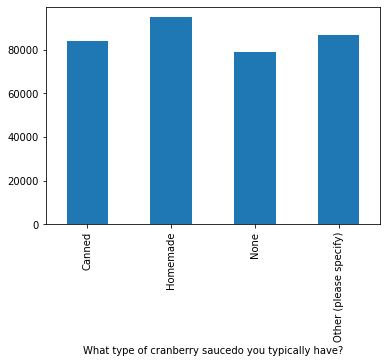

In [35]:
%matplotlib inline

sauce = grouped.agg(np.mean)
sauce["income"].plot(kind="bar")

## Aggregating with multiple columns
We can call groupby with multiple columns as input to get more granular groups. If we use the What type of cranberry saucedo you typically have? and What is typically the main dish at your Thanksgiving dinner? columns as input, we'll be able to find the average income of people who eat Homemade cranberry sauce and Tofurkey, for example:

In [36]:
grouped = data.groupby(
    ["What type of cranberry saucedo you typically have?", 
     "What is typically the main dish at your Thanksgiving dinner?"])
grouped.agg(np.mean)

RespondentID  \
What type of cranberry saucedo you typically have? What is typically the main dish at your Thanksg...                 
Canned                                             Chicken                                             4.336354e+09   
                                                   Ham/Pork                                            4.336757e+09   
                                                   I don't know                                        4.335987e+09   
                                                   Other (please specify)                              4.336682e+09   
                                                   Roast beef                                          4.336254e+09   
                                                   Tofurkey                                            4.337157e+09   
                                                   Turkey                                              4.336705e+09   
Homemade                                           Chicken                                             4.336540e+09   
                                                   Ham/Pork                                            4.337253e+09   
                                                   I don't know                                        4.336084e+09   
                                                   Other (please specify)                              4.336863e+09   
                                                   Roast beef                                          4.336174e+09   
                                                   Tofurkey                                            4.336790e+09   
                                                   Turducken                                           4.337475e+09   
                                                   Turkey                                              4.336791e+09   
None                                               Chicken                                             4.336151e+09   
                                                   Ham/Pork                                            4.336680e+09   
                                                   I don't know                                        4.336412e+09   
                                                   Other (please specify)                              4.336688e+09   
                                                   Roast beef                                          4.337424e+09   
                                                   Tofurkey                                            4.336950e+09   
                                                   Turducken                                           4.336739e+09   
                                                   Turkey                                              4.336784e+09   
Other (please specify)                             Ham/Pork                                            4.336465e+09   
                                                   Other (please specify)                              4.337335e+09   
                                                   Tofurkey                                            4.336122e+09   
                                                   Turkey                                              4.336724e+09   

                                                                                                              income  
What type of cranberry saucedo you typically have? What is typically the main dish at your Thanksg...                 
Canned                                             Chicken                                              80999.600000  
                                                   Ham/Pork                                             77499.535714  
                                                   I don't know                                          4999.500000  
                                                   Other

As you can see above, we get a nice table that shows us the mean of each column for each group. This enables us to find some interesting patterns, such as:

* People who have Turducken and Homemade cranberry sauce seem to have high household incomes.
* People who eat Canned cranberry sauce tend to have lower incomes, but those who also have Roast Beef have the lowest incomes.
* It looks like there's one person who has Canned cranberry sauce and doesn't know what type of main dish he's having.

## Aggregating with multiple functions
We can also perform aggregation with multiple functions. This enables us to calculate the mean and standard deviation of a group, for example. In the below code, we find the sum, standard deviation, and mean of each group in the income column:

In [37]:
grouped["income"].agg([np.mean, np.sum, np.std]).head(10)

mean  \
What type of cranberry saucedo you typically have? What is typically the main dish at your Thanksg...                  
Canned                                             Chicken                                              80999.600000   
                                                   Ham/Pork                                             77499.535714   
                                                   I don't know                                          4999.500000   
                                                   Other (please specify)                               53213.785714   
                                                   Roast beef                                           25499.500000   
                                                   Tofurkey                                            100713.857143   
                                                   Turkey                                               85242.682045   
Homemade                                           Chicken                                              19999.500000   
                                                   Ham/Pork                                             96874.625000   
                                                   I don't know                                                  NaN   

                                                                                                              sum  \
What type of cranberry saucedo you typically have? What is typically the main dish at your Thanksg...               
Canned                                             Chicken                                               404998.0   
                                                   Ham/Pork                                             1084993.5   
                                                   I don't know                                            4999.5   
                                                   Other (please specify)                                372496.5   
                                                   Roast beef                                            127497.5   
                                                   Tofurkey                                              704997.0   
                                                   Turkey                                              34182315.5   
Homemade                                           Chicken                                                59998.5   
                                                   Ham/Pork                                              387498.5   
                                                   I don't know                                               0.0   

                                                                                                                std  
What type of cranberry saucedo you typically have? What is typically the main dish at your Thanksg...                
Canned                                             Chicken                                             75779.481062  
                                                   Ham/Pork                                            56645.063944  
                                                   I don't know                                                 NaN  
                                                   Other (please specify)                              29780.946290  
                                                   Roast beef                                          24584.039538  
                                                   Tofurkey                                            61351.484439  
                                                   Turkey                                              55687.436102  
Homemade                                           Chicken                                             16393.596311  
                                                   Ham/Pork                           

## Using apply on groups
One of the limitations of aggregation is that each function has to return a single number. While we can perform computations like finding the mean, we can't for example, call ```value_counts``` to get the exact count of a category. We can do this using the ```pandas.GroupBy.apply``` method. This method will apply a function to each group, then combine the results.

In the below code, we'll apply value_counts to find the number of people who live in each area type (Rural, Suburban, etc) who eat different kinds of main dishes for Thanksgiving:

In [38]:
grouped = data.groupby("How would you describe where you live?")["What is typically the main dish at your Thanksgiving dinner?"]
grouped.apply(lambda x: x.value_counts())

How would you describe where you live?                        
Rural                                   Turkey                    189
                                        Other (please specify)      9
                                        Ham/Pork                    7
                                        Tofurkey                    3
                                        I don't know                3
                                        Turducken                   2
                                        Chicken                     2
                                        Roast beef                  1
Suburban                                Turkey                    449
                                        Ham/Pork                   17
                                        Other (please specify)     13
                                        Tofurkey                    9
                                        Chicken                     3
                           

The above table shows us that people who live in different types of areas eat different Thanksgiving main dishes at about the same rate.